## Define generator

In [1]:
"""
If you use this code, please the SynthSR paper in:
https://github.com/BBillot/SynthSR/blob/master/bibtex.bib

Copyright 2020 Benjamin Billot

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in
compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is
distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
implied. See the License for the specific language governing permissions and limitations under the
License.
"""

# print information
print('\n')
print('SynthSR prediction')
print('\n')

# python imports
import os
import sys
import numpy as np
from argparse import ArgumentParser
!export PATH=/usr/local/cuda-10.0/bin:$PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-10.0/lib64:$LD_LIBRARY_PATH
synthSR_home = '/home/viscent/hdd/viscent/SynthSR'
print(synthSR_home)
sys.path.append(synthSR_home)
from ext.neuron import models as nrn_models
from ext.lab2im import utils
from ext.lab2im import edit_volumes
import os


# python imports
import os
import keras
import numpy as np
import tensorflow as tf
from keras import models
import keras.callbacks as KC
from keras.optimizers import Adam
from inspect import getmembers, isclass
import matplotlib.pyplot as plt
import SimpleITK as sitk
import scipy.ndimage as ndimage

# project imports
from SynthSR.brain_generator import BrainGenerator
from SynthSR.metrics_model import metrics_model, IdentityLoss, add_seg_loss_to_model

# third-party imports
from ext.lab2im import utils
from ext.lab2im import layers as l2i_layers
from ext.neuron import layers as nrn_layers
from ext.neuron import models as nrn_models


def build_brain_gen(labels_dir,
             model_dir,
             prior_means,
             prior_stds,
             path_generation_labels,
             segmentation_label_list=None,
             segmentation_label_equivalency=None,
             segmentation_model_file=None,
             fs_header_segnet=False,
             relative_weight_segmentation=0.25,
             prior_distributions='normal',
             images_dir=None,
             path_generation_classes=None,
             FS_sort=True,
             batchsize=1,
             input_channels=True,
             output_channel=0,
             target_res=None,
             output_shape=None,
             flipping=True,
             padding_margin=None,
             scaling_bounds=0.15,
             rotation_bounds=15,
             shearing_bounds=0.02,
             translation_bounds=5,
             nonlin_std=4.,
             nonlin_shape_factor=0.03125,
             simulate_registration_error=True,
             data_res=None,
             thickness=None,
             randomise_res=None,
             downsample=True,
             blur_range=1.15,
             build_reliability_maps=True,
             bias_field_std=.3,
             bias_shape_factor=0.03125,
             n_levels=5,
             nb_conv_per_level=2,
             conv_size=3,
             unet_feat_count=24,
             feat_multiplier=2,
             dropout=0,
             activation='elu',
             lr=1e-4,
             lr_decay=0,
             epochs=100,
             steps_per_epoch=1000,
             regression_metric='l1',
             work_with_residual_channel=None,
             loss_cropping=None,
             checkpoint=None,
             model_file_has_different_lhood_layer=False,
             output_labels=False):
    """
    This function trains a Unet to do slice imputation (and possibly synthesis) of MRI images with thick slices,
    using synthetic scans and possibly real scans.

    :param labels_dir: path of folder with all input label maps, or to a single label map (if only one training example)
    :param model_dir: path of a directory where the models will be saved during training.
    :param images_dir: directory with real images corresponding to the training label maps. These will be taken as
    regression target. We recommend skull stripping them.

    #---------------------------------------------- Generation parameters ----------------------------------------------
    # label maps parameters
    :param path_generation_labels: list of all possible label values in the input label maps.
    Must be the path to a 1d numpy array, which should be organised as follows: background label first, then non-sided
    labels (e.g. CSF, brainstem, etc.), then all the structures of the same hemisphere (can be left or right), and
    finally all the corresponding contralateral structures (in the same order).
    Example: [background_label, non-sided_1, ..., non-sided_n, left_1, ..., left_m, right_1, ..., right_m]
    :param FS_sort: whether us FS_sort when creating list of labels with utils.get_list_labels. Default is True.

    # output-related parameters
    :param batchsize: (optional) number of images to generate per mini-batch. Default is 1.
    :param input_channels: (optional) list of booleans indicating if each *synthetic* channel is going to be used as an
    input for the downstream network. This also enables to know how many channels are going to be synthesised. Default
    is True, which means generating 1 channel, and use it as input (either for plain SR with a synthetic target, or for
    synthesis with a real target).
    :param output_channel: (optional) a list with the indices of the output channels  (i.e. the synthetic regression
    targets), if no real images were provided as regression target. Set to None if using real images as targets. Default
    is the first channel (index 0).
    :param target_res: (optional) target resolution of the generated images and corresponding label maps.
    If None, the outputs will have the same resolution as the input label maps.
    Can be a number (isotropic resolution), or the path to a 1d numpy array.
    :param output_shape: (optional) desired shape of the output image, obtained by randomly cropping the generated image
    Can be an integer (same size in all dimensions), a sequence, a 1d numpy array, or the path to a 1d numpy array.
    Default is None, where no cropping is performed.

    # GMM-sampling parameters
    :param path_generation_classes: (optional) Indices regrouping generation labels into classes of same intensity
    distribution. Regouped labels will thus share the same Gaussian when samling a new image. Should be the path to a 1d
    numpy array with the same length as generation_labels. and contain values between 0 and K-1, where K is the total
    number of classes. Default is all labels have different classes.
    :param prior_distributions: (optional) type of distribution from which we sample the GMM parameters.
    Can either be 'uniform', or 'normal'. Default is 'normal'.
    :param prior_means: (optional) hyperparameters controlling the prior distributions of the GMM means. Because
    these prior distributions are uniform or normal, they require by 2 hyperparameters. Can be a path to:
    1) an array of shape (2, K), where K is the number of classes (K=len(generation_labels) if generation_classes is
    not given). The mean of the Gaussian distribution associated to class k in [0, ...K-1] is sampled at each mini-batch
    from U(prior_means[0,k], prior_means[1,k]) if prior_distributions is uniform, and from
    N(prior_means[0,k], prior_means[1,k]) if prior_distributions is normal.
    2) an array of shape (2*n_mod, K), where each block of two rows is associated to hyperparameters derived
    from different modalities. In this case, if use_specific_stats_for_channel is False, we first randomly select a
    modality from the n_mod possibilities, and we sample the GMM means like in 2).
    If use_specific_stats_for_channel is True, each block of two rows correspond to a different channel
    (n_mod=n_channels), thus we select the corresponding block to each channel rather than randomly drawing it.
    Default is None, which corresponds all GMM means sampled from uniform distribution U(25, 225).
    :param prior_stds: (optional) same as prior_means but for the standard deviations of the GMM.
    Default is None, which corresponds to U(5, 25).

    # spatial deformation parameters
    :param flipping: (optional) whether to introduce right/left random flipping. Default is True.
    :param  padding_margin: useful when cropping the loss but you are not using very large patches. Set to None for
    determining it automatically from loss_cropping (not recommended if you use big volume sizes)
    :param scaling_bounds: (optional) if apply_linear_trans is True, the scaling factor for each dimension is
    sampled from a uniform distribution of predefined bounds. Can either be:
    1) a number, in which case the scaling factor is independently sampled from the uniform distribution of bounds
    (1-scaling_bounds, 1+scaling_bounds) for each dimension.
    2) the path to a numpy array of shape (2, n_dims), in which case the scaling factor in dimension i is sampled from
    the uniform distribution of bounds (scaling_bounds[0, i], scaling_bounds[1, i]) for the i-th dimension.
    3) False, in which case scaling is completely turned off.
    Default is scaling_bounds = 0.15 (case 1)
    :param rotation_bounds: (optional) same as scaling bounds but for the rotation angle, except that for case 1 the
    bounds are centred on 0 rather than 1, i.e. (0+rotation_bounds[i], 0-rotation_bounds[i]).
    Default is rotation_bounds = 15.
    :param shearing_bounds: (optional) same as scaling bounds. Default is shearing_bounds = 0.012.
    :param translation_bounds: (optional) same as scaling bounds. Default is translation_bounds = False, but we
    encourage using it when cropping is deactivated (i.e. when output_shape=None).
    :param nonlin_std: (optional) Standard deviation of the normal distribution from which we sample the first
    tensor for synthesising the deformation field. Set to 0 to completely turn the elastic deformation off.
    :param nonlin_shape_factor: (optional) Ratio between the size of the input label maps and the size of the sampled
    tensor for synthesising the elastic deformation field.
    :param simulate_registration_error: (optional) whether to simulate registration errors between *synthetic* channels.
    Can be a single value (same for all channels) or a list with one value per *synthetic* channel. For the latter,
    the first value will automatically be reset to True since the first channel is used as reference. Default is True.

    # blurring/resampling parameters
    :param randomise_res: (optional) whether to mimic images that would have been 1) acquired at low resolution, and
    2) resampled to high resolution. The low resolution is uniformly sampled at each minibatch from [1mm, 9mm].
    In that process, the images generated by sampling the GMM are: 1) blurred at LR, 2) downsampled at LR, and
    3) resampled at target_resolution.
    :param data_res: (optional) specific acquisition resolution to mimic, as opposed to random resolution sampled when
    randomis_res is True. This triggers a blurring which mimics the acquisition resolution, but downsampling is optional
    (see param downsample). Default for data_res is None, where images are slighlty blurred. If the generated images are
    uni-modal, data_res can be a number (isotropic acquisition resolution), a sequence, a 1d numpy array, or the path
    to a 1d numy array. In the multi-modal case, it should be given as a umpy array (or a path) of size (n_mod, n_dims),
    where each row is the acquisition resolution of the corresponding channel.
    :param thickness: (optional) if data_res is provided, we can further specify the slice thickness of the low
    resolution images to mimic. Must be provided in the same format as data_res. Default thickness = data_res.
    :param downsample: (optional) whether to actually downsample the volume images to data_res after blurring.
    Default is False, except when thickness is provided, and thickness < data_res.
    :param blur_range: (optional) Randomise the standard deviation of the blurring kernels, (whether data_res is given
    or not). At each mini_batch, the standard deviation of the blurring kernels are multiplied by a coefficient sampled
    from a uniform distribution with bounds [1/blur_range, blur_range]. If None, no randomisation. Default is 1.15.
    :param build_reliability_maps: set to True if you want to build soft masks indicating which voxels are
    "measured" and which are interpolated

    # bias field parameters
    :param bias_field_std: (optional) If strictly positive, this triggers the corruption of synthesised images with a
    bias field. This will only affect the input channels (i.e. not the synthetic regression target). The bias field is
    obtained by sampling a first small tensor from a normal distribution, resizing it to full size, and rescaling it to
    positive values by taking the voxel-wise exponential. bias_field_std designates the std dev of the normal
    distribution from which we sample the first tensor. Set to 0 to completely deactivate biad field corruption.
    :param bias_shape_factor: (optional) If bias_field_std is not False, this designates the ratio between the size of
    the input label maps and the size of the first sampled tensor for synthesising the bias field.

    # ------------------------------------------ UNet architecture parameters ------------------------------------------
    :param n_levels: (optional) number of level for the Unet. Default is 5.
    :param nb_conv_per_level: (optional) number of convolutional layers per level. Default is 2.
    :param conv_size: (optional) size of the convolution kernels. Default is 2.
    :param unet_feat_count: (optional) number of feature for the first layr of the Unet. Default is 24.
    :param feat_multiplier: (optional) multiply the number of feature by this nummber at each new level. Default is 2.
    :param dropout: (optional) probability of dropout for the Unet. Deafult is 0, where no dropout is applied.
    :param activation: (optional) activation function. Can be 'elu', 'relu'.

    # ----------------------------------------------- Training parameters ----------------------------------------------
    :param lr: (optional) learning rate for the training. Default is 1e-4
    :param lr_decay: (optional) learing rate decay. Default is 0, where no decay is applied.
    :param epochs: (optional) number of epochs.
    :param steps_per_epoch: (optional) number of steps per epoch. Default is 1000. Since no online validation is
    possible, this is equivalent to the frequency at which the models are saved.
    :param regression_metric: (optional) loss used in training. Can be 'l1' (default), 'l2', 'ssim', or 'laplace'
    :param work_with_residual_channel: (optional) if you have a channel that is similar to the output (e.g., in
    imputation), it is convenient to predict the residual, rather than the image from scratch. This parameter is a list
    of indices of the synthetic channels you want to add the residual to (must have the same length as output_channels,
    or have length equal to 1 if real images are used)
    :param loss_cropping: (option)  to crop the posteriors when evaluating the loss function (specify the output size
    Can be an int, or the path to a 1d numpy array.
    :param checkpoint: (optional) path of an already saved model to load before starting the training.
    :param model_file_has_different_lhood_layer: (optional) set to True if eg you're loading weights from a segmetation
    (rather than SR/synthesis) net. Useful to use models pretrained with SynthSeg or different number of channels

    # ----------------------------------------------- Regularize with pretrained segmentation CNN-----------------------
    :param segmentation_model_file: (optional) h5 model file with the weights of the segmentation model. For now, we
    assume a Unet architecture with the shame shape as the synthesis / SR Unet. Set to None not to use.
    :param fs_header_segnet: set to True if the segmentation network expects data in FS orientation (rather than the
    default diagonal voxel-to-ras matrix).
    :param segmentation_label_list: (optional) npy/npz file with an array with the list of labels segmented by the Unet
    :param segmentation_label_equivalency: (optional) npy/npz file with an array with as many elements as
    segmentation_label_list, pinpointing to which generation labels the segmentation labels correspond (set to -1 if you
    don't want to use a label in the loss). You can use this array e.g., to merge left and right structures, ignore
    structures...
    :param relative_weight_segmentation: (optional) relative weight of the Dice loss, compared with the image term loss
    (eg., l1 or l2)
    """

    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
        # 设置 GPU 显存占用为按需分配，增长式
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # 异常处理
            print(e)

    n_channels = len(utils.reformat_to_list(input_channels))

    # convert output_channel and work_with_residual_channel to lists
    if output_channel is not None:
        output_channel = list(utils.reformat_to_list(output_channel))
        n_output_channels = len(output_channel)
    else:
        n_output_channels = 1

    # various checks
    if (images_dir is None) & (output_channel is None):
        raise Exception('please provide a value for output_channel or image_dir')
    elif (images_dir is not None) & (output_channel is not None):
        raise Exception('please provide a value either for output_channel or image_dir, but not both at the same time')
    if output_channel is not None:
        if any(x >= n_channels for x in output_channel):
            raise Exception('indices in output_channel cannot be greater than the total number of channels')

    # check work_with_residual_channel
    if work_with_residual_channel is not None:
        work_with_residual_channel = utils.reformat_to_list(work_with_residual_channel)
        if output_channel is not None:
            if len(work_with_residual_channel) != len(output_channel):
                raise Exception('The number or residual channels and output channels must be the same')

        if any(x >= n_channels for x in work_with_residual_channel):
            raise Exception('indices in work_with_residual_channel cannot be greater than the total number of channels')

        if build_reliability_maps:  # consider indices of reliability maps
            work_with_residual_channel = 2 * work_with_residual_channel

    # get label lists
    generation_labels, n_neutral_labels = utils.get_list_labels(label_list=path_generation_labels,
                                                                labels_dir=labels_dir,
                                                                FS_sort=FS_sort)

    # prepare model folder
    utils.mkdir(model_dir)

    # compute padding_margin if needed
    if loss_cropping == 0:
        padding_margin = None
    elif padding_margin is None:
        padding_margin = utils.get_padding_margin(output_shape, loss_cropping)
    print('Building gen...')
    # instantiate BrainGenerator object
    brain_generator = BrainGenerator(labels_dir=labels_dir,
                                     images_dir=images_dir,
                                     generation_labels=generation_labels,
                                     n_neutral_labels=n_neutral_labels,
                                     padding_margin=padding_margin,
                                     batchsize=batchsize,
                                     input_channels=input_channels,
                                     output_channel=output_channel,
                                     target_res=target_res,
                                     output_shape=output_shape,
                                     output_div_by_n=2 ** n_levels,
                                     generation_classes=path_generation_classes,
                                     prior_means=prior_means,
                                     prior_stds=prior_stds,
                                     prior_distributions=prior_distributions,
                                     flipping=flipping,
                                     scaling_bounds=scaling_bounds,
                                     rotation_bounds=rotation_bounds,
                                     shearing_bounds=shearing_bounds,
                                     translation_bounds=translation_bounds,
                                     nonlin_std=nonlin_std,
                                     nonlin_shape_factor=nonlin_shape_factor,
                                     simulate_registration_error=simulate_registration_error,
                                     randomise_res=randomise_res,
                                     data_res=data_res,
                                     thickness=thickness,
                                     downsample=downsample,
                                     blur_range=blur_range,
                                     build_reliability_maps=build_reliability_maps,
                                     bias_field_std=bias_field_std,
                                     bias_shape_factor=bias_shape_factor,
                                     output_labels=output_labels)
    print('Gen Done!')
    # transformation model
    labels_to_image_model = brain_generator.labels_to_image_model
    unet_input_shape = brain_generator.model_output_shape
    print('Transform done!')
    # prepare the Unet model
    if regression_metric == 'laplace':
        nb_labels_unet = 2 * n_output_channels
    else:
        nb_labels_unet = n_output_channels
    print('Building Unet...')

    input_generator = utils.build_training_generator(brain_generator.model_inputs_generator, batchsize)
    input_generator = brain_generator.model_inputs_generator

    # model
    # model = models.Model(model.inputs, model.output)
    return input_generator, labels_to_image_model, unet_input_shape, nb_labels_unet, brain_generator




SynthSR prediction


/home/viscent/hdd/viscent/SynthSR


Using TensorFlow backend.


In [2]:
import os
from pathlib import Path
home_dir = '/media/hdd/viscent'

# change directory (to import SynthSR code) - NOT REQUIRED IF RUNNING FROM COMMAND LINE?
#os.chdir(home_dir+'/Python/github/SynthSR')

import sys
sys.path.insert(0,os.path.join(home_dir,'SynthSR'))

import numpy as np

data_dir = '/media/hdd/dhcp/dhcp_lores'

# we have to specify a model dir, where the models will be saved after each epoch
#model_dir = '../../data/generated_images/7-training'  # folder where they will be saved
model_dir = os.path.join(home_dir,'SynthSR','models','all_to_t1')  # folder where they will be saved

# we specify the Unet architecture
n_levels = 5  # number of levels in the UNet
nb_conv_per_level = 2  # number of convolution per level
conv_size = 3  # size of the convolution kernels
unet_feat_count = 24  # number of feature maps after the very first layer of the network
# here we double the number of feature maps after each max-pooling operation. Incidentally, the number of features will
# be halved after each upsampling step. Set to 1 to keep the number of feature maps constant throughout the network.
feat_multiplier = 2
dropout = 0  # We recommend not using dropout
activation = 'elu'  # activation function

# we now set the learning parameters
learning_rate = 1e-4  # learning rate to apply
lr_decay = 0   # here we do not use a decay. I fyou do, remember that it will be applied at each step !
# An epoch is defined by a given number of steps (rather than the fact to have gone through all the training examples).
# This choice is motivated by the fact that we typically have a small amount of data in medical imaging analysis.
# At each step, we randomly select a training label map, generate the training data, run the input channels through the
# network, compute the regression metric between the prediction and the regresion target, and finally backpropagate.
# We set here the number of epochs and steps per epoch to low values, as this is just an example, but it would typically
# be 200 epochs with 1,000 steps each.
epochs = 200  # number of epochs
steps_per_epoch = 4000  # number of steps per epoch
regression_metric = 'l1'  # metric used to compute the loss function
# In this example, the regression target and one of the input channels have the same contrast (T1 scan). Therefore, it
# is easier to predict the residuals between the two. To do that we need to indicate the index of the input channel to
# add the residuals to
#work_with_residual_channel = 1
work_with_residual_channel = 0 # changed to 0 (as scenario is not multimodal and hence has only one channel)

# We now set the generation parameters, same as before

# data paths
#labels_folder = '../../data/labels'
#images_folder = None
labels_folder = data_dir+'/labels'  # 1 mm isotropic
images_folder = data_dir+'/images_t1'   # 1 mm isotropic

# # general parameters
# input_channels = [False, True, True]  # specify which channel will be used as input channel for the network
# output_channel = 0   # index corresponding to the regression target
# target_res = None
# output_shape = 128
# copied from 1-SR_real_dhcp
input_channels = [True, True]
output_channel = None
target_res = None
output_shape = None

# GMM-sampling parameters
# generation_labels = '../../data/labels_classes_priors/generation_labels.npy'
# generation_classes = '../../data/labels_classes_priors/generation_classes.npy'
# prior_means_t1_hr = np.load('../../data/labels_classes_priors/prior_means_t1_hr.npy')
# prior_means_t1_lr = np.load('../../data/labels_classes_priors/prior_means_t1_lr.npy')
# prior_means_t2 = np.load('../../data/labels_classes_priors/prior_means_t2.npy')
# prior_means = np.concatenate([prior_means_t1_hr, prior_means_t1_lr, prior_means_t2], axis=0)
# prior_stds_t1_hr = np.load('../../data/labels_classes_priors/prior_stds_t1_hr.npy')
# prior_stds_t1_lr = np.load('../../data/labels_classes_priors/prior_stds_t1_lr.npy')
# prior_stds_t2 = np.load('../../data/labels_classes_priors/prior_stds_t2.npy')
# prior_stds = np.concatenate([prior_stds_t1_hr, prior_stds_t1_lr, prior_stds_t2], axis=0)

generation_labels = home_dir+'/SynthSR/data/labels_classes_priors/generation_labels.npy'
generation_classes = home_dir+'/SynthSR/data/labels_classes_priors/generation_classes.npy'
generation_labels = np.array(range(0,10))
generation_classes = np.array(range(0,10))
prior_means = home_dir+'/SynthSR/data/estimated_priors/prior_means.npy'
prior_stds = home_dir+'/SynthSR/data/estimated_priors/prior_stds.npy'

# augmentation parameters
flipping = False
scaling_bounds = 0.1
rotation_bounds = 8
shearing_bounds = 0.01
translation_bounds = False
nonlin_std = 0
bias_field_std = 0

# blurring/downsampling parameters
#data_res = np.array([[1., 1., 3.], [1., 4.5, 1.]])  # slice spacing for the input channels only
#thickness = np.array([[1., 1., 3.], [1., 3., 1.]])
# Hyperfine resolution
data_res = np.array([1.5, 1.5, 5.])  # slice spacing i.e. resolution to mimic
thickness = np.array([1.5, 1.5, 5.])  # slice thickness

downsample = True
build_reliability_maps = True
blur_range = 1.15
simulate_registration_error = True

print(prior_means)
print(prior_stds)

########################################################################################################

# launch training
input_generator, labels_to_image_model, unet_input_shape, nb_labels_unet, brain_generator=build_brain_gen(labels_folder,
         model_dir,
         prior_means,
         prior_stds,
         images_dir=images_folder,
         path_generation_labels=generation_labels,
         path_generation_classes=generation_classes,
         batchsize=1,
         input_channels=input_channels,
         output_channel=output_channel,
         target_res=target_res,
         output_shape=output_shape,
         flipping=flipping,
         scaling_bounds=scaling_bounds,
         rotation_bounds=rotation_bounds,
         shearing_bounds=shearing_bounds,
         translation_bounds=translation_bounds,
         nonlin_std=nonlin_std,
         simulate_registration_error=True,
         data_res=data_res,
         thickness=thickness,
         downsample=downsample,
         randomise_res=False,
         blur_range=blur_range,
         build_reliability_maps=build_reliability_maps,
         bias_field_std=bias_field_std,
         n_levels=n_levels,
         nb_conv_per_level=nb_conv_per_level,
         conv_size=conv_size,
         unet_feat_count=unet_feat_count,
         feat_multiplier=feat_multiplier,
         dropout=dropout,
         activation=activation,
         lr=learning_rate,
         lr_decay=lr_decay,
         epochs=epochs,
         steps_per_epoch=steps_per_epoch,
         regression_metric=regression_metric,
         work_with_residual_channel=work_with_residual_channel,
         output_labels=True)

/media/hdd/viscent/SynthSR/data/estimated_priors/prior_means.npy
/media/hdd/viscent/SynthSR/data/estimated_priors/prior_stds.npy
Building gen...
/media/hdd/dhcp/dhcp_lores/labels


2022-04-27 17:09:17.970022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-04-27 17:09:17.990681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 17:09:17.990777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:08:00.0
2022-04-27 17:09:17.990865: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/viscent/software/Slicer-4.11/lib:/home/viscent/software/itksnap-3.8.0-qt4/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda-11.6/lib64:
2022-04-27 17:09:17.990919: 

Gen Done!
Transform done!
Building Unet...


(96, 128, 128, 4)


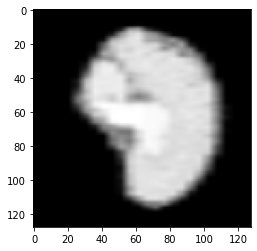

In [3]:
image, target, label=brain_generator.generate_brain()
image=edit_volumes.align_volume_to_ref(image, np.eye(4),
aff_ref=brain_generator.aff, n_dims=brain_generator.n_dims)
target=edit_volumes.align_volume_to_ref(target, np.eye(4),
aff_ref=brain_generator.aff, n_dims=brain_generator.n_dims)
label=edit_volumes.align_volume_to_ref(label, np.eye(4),
aff_ref=brain_generator.aff, n_dims=brain_generator.n_dims)
plt.imshow(image[48,...,0], cmap='gray')
print(image.shape)

In [4]:
list_inputs = next(input_generator)
[image, target, label] = labels_to_image_model.predict(list_inputs)

In [5]:
image.shape

(1, 96, 128, 128, 4)

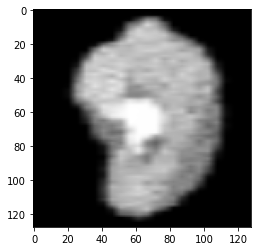

In [6]:
plt.imshow(image[0,48,...,0], cmap='gray')

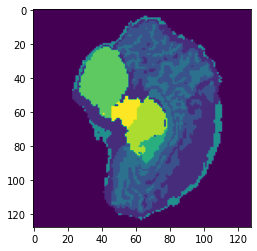

In [7]:
plt.imshow(label[0,48,...,0])

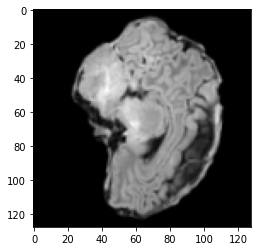

In [8]:
plt.imshow(target[0,48,...,0], cmap='gray')

In [9]:
# print(prior_means)
# means = np.load(prior_means)

In [10]:
# means

In [12]:
from tqdm import trange
output_path = os.path.join(synthSR_home, 'generated_data_multimodal')
if not os.path.exists(output_path):
    os.makedirs(output_path)
for i in trange(1000):
    list_inputs = next(input_generator)
    [image, target, label] = labels_to_image_model.predict(list_inputs)
    prefix = str(f"{i:04d}")+"_"
    sitk.WriteImage(sitk.GetImageFromArray(image[0,...,0]), os.path.join(output_path, prefix+'image_t1.nii.gz'))
    sitk.WriteImage(sitk.GetImageFromArray(image[0,...,2]), os.path.join(output_path, prefix+'image_t2.nii.gz'))
    sitk.WriteImage(sitk.GetImageFromArray(label[0,...,0]), os.path.join(output_path, prefix+'label.nii.gz'))
    sitk.WriteImage(sitk.GetImageFromArray(target[0,...,0]), os.path.join(output_path, prefix+'target.nii.gz'))

100%|██████████| 1000/1000 [17:15<00:00,  1.04s/it]
